In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau


/home/mmc/anaconda3/envs/CPR_YOLO/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "3"

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
    
# 커스텀 클래스 이름 정의
CUSTOM_CLASSES = ['background', 'drink', 'snack', 'Human_hand']


In [3]:
# 커스텀 데이터셋 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_name = os.path.splitext(self.images[idx])[0] + '.png'  # PNG 파일 확장자 가정
        mask_path = os.path.join(self.mask_dir, mask_name)
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = np.array(mask)
            mask[mask == 255] = 1  # 'drink' 클래스
            mask[mask == 150] = 2  # 'snack' 클래스
            mask[mask == 100] = 3  # 'Human_hand' 클래스
            mask[(mask != 1) & (mask != 2) & (mask != 3)] = 0 # 배경 클래스
            mask = torch.tensor(mask, dtype=torch.long)


        return image, mask

# 학습 데이터 전처리 및 증강
train_transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(),  # 랜덤 수평 뒤집기
    # transforms.RandomRotation(10),      # 랜덤 회전 (±10도)
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # 밝기, 대비, 채도, 색조 변화
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 검증 데이터 전처리 (정규화만 적용)
val_transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
# 학습 및 검증 데이터셋과 데이터로더
train_dataset = CustomDataset(image_dir='./images_224/train', mask_dir='./masks_224/train', transform=train_transform)
val_dataset = CustomDataset(image_dir='./images_224/val', mask_dir='./masks_224/val', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [5]:
# 모델 준비
num_classes = len(CUSTOM_CLASSES)
# model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)

model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=1)  # num_classes는 커스텀 데이터셋의 클래스 수
model = model.to(device)

/home/mmc/anaconda3/envs/CPR_YOLO/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mmc/anaconda3/envs/CPR_YOLO/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:

# 손실 함수 및 옵티마이저 설정
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 학습률 스케줄러 설정
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


/home/mmc/anaconda3/envs/CPR_YOLO/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100: 100%|██████████| 7/7 [00:04<00:00,  1.46batch/s]


Epoch [1/100], Loss: 0.9980
Epoch [1/100], Validation Loss: 8.4154
Saved best model with validation loss: 8.4154


Epoch 2/100: 100%|██████████| 7/7 [00:02<00:00,  2.96batch/s]


Epoch [2/100], Loss: 0.5988
Epoch [2/100], Validation Loss: 3.4949
Saved best model with validation loss: 3.4949


Epoch 3/100: 100%|██████████| 7/7 [00:02<00:00,  2.94batch/s]


Epoch [3/100], Loss: 0.4676
Epoch [3/100], Validation Loss: 1.0982
Saved best model with validation loss: 1.0982


Epoch 4/100: 100%|██████████| 7/7 [00:02<00:00,  2.84batch/s]


Epoch [4/100], Loss: 0.4125
Epoch [4/100], Validation Loss: 0.6832
Saved best model with validation loss: 0.6832


Epoch 5/100: 100%|██████████| 7/7 [00:02<00:00,  3.06batch/s]


Epoch [5/100], Loss: 0.3625
Epoch [5/100], Validation Loss: 0.6383
Saved best model with validation loss: 0.6383


Epoch 6/100: 100%|██████████| 7/7 [00:02<00:00,  3.08batch/s]


Epoch [6/100], Loss: 0.3703
Epoch [6/100], Validation Loss: 0.5015
Saved best model with validation loss: 0.5015


Epoch 7/100: 100%|██████████| 7/7 [00:02<00:00,  3.07batch/s]


Epoch [7/100], Loss: 0.3446
Epoch [7/100], Validation Loss: 0.4619
Saved best model with validation loss: 0.4619


Epoch 8/100: 100%|██████████| 7/7 [00:02<00:00,  2.95batch/s]


Epoch [8/100], Loss: 0.3258
Epoch [8/100], Validation Loss: 0.4247
Saved best model with validation loss: 0.4247


Epoch 9/100: 100%|██████████| 7/7 [00:02<00:00,  2.99batch/s]


Epoch [9/100], Loss: 0.3188
Epoch [9/100], Validation Loss: 0.4115
Saved best model with validation loss: 0.4115


Epoch 10/100: 100%|██████████| 7/7 [00:02<00:00,  2.96batch/s]


Epoch [10/100], Loss: 0.3125
Epoch [10/100], Validation Loss: 0.4862


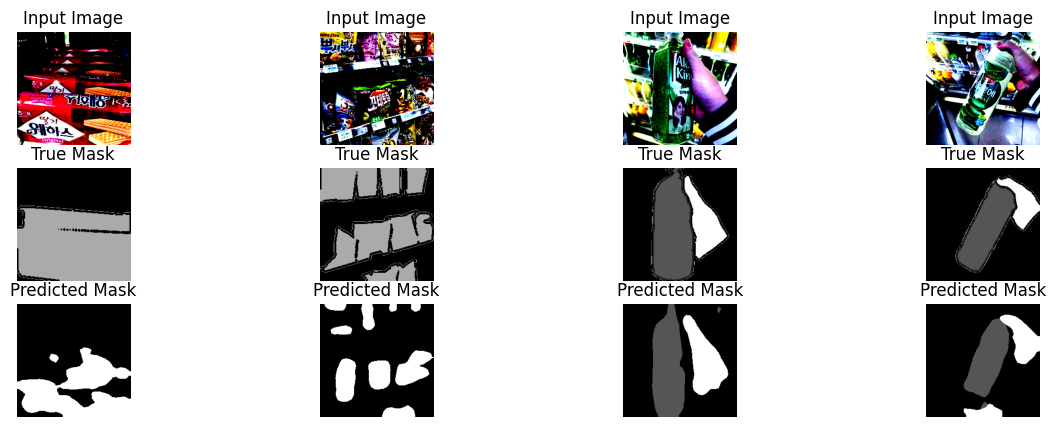

Epoch 11/100: 100%|██████████| 7/7 [00:02<00:00,  2.93batch/s]


Epoch [11/100], Loss: 0.3237
Epoch [11/100], Validation Loss: 0.9113


Epoch 12/100: 100%|██████████| 7/7 [00:02<00:00,  2.95batch/s]


Epoch [12/100], Loss: 0.3194
Epoch [12/100], Validation Loss: 0.5335


Epoch 13/100: 100%|██████████| 7/7 [00:02<00:00,  2.95batch/s]


Epoch [13/100], Loss: 0.2955
Epoch [13/100], Validation Loss: 0.4104
Saved best model with validation loss: 0.4104


Epoch 14/100: 100%|██████████| 7/7 [00:02<00:00,  2.90batch/s]


Epoch [14/100], Loss: 0.2698
Epoch [14/100], Validation Loss: 0.4202


Epoch 15/100: 100%|██████████| 7/7 [00:02<00:00,  2.92batch/s]


Epoch [15/100], Loss: 0.2515
Epoch [15/100], Validation Loss: 0.4883


Epoch 16/100: 100%|██████████| 7/7 [00:02<00:00,  2.85batch/s]


Epoch [16/100], Loss: 0.2364
Epoch [16/100], Validation Loss: 0.4106


Epoch 17/100: 100%|██████████| 7/7 [00:02<00:00,  2.97batch/s]


Epoch [17/100], Loss: 0.2194
Epoch [17/100], Validation Loss: 0.4408


Epoch 18/100: 100%|██████████| 7/7 [00:02<00:00,  2.95batch/s]


Epoch [18/100], Loss: 0.2050
Epoch [18/100], Validation Loss: 0.4322


Epoch 19/100: 100%|██████████| 7/7 [00:02<00:00,  2.88batch/s]


Epoch [19/100], Loss: 0.2041
Epoch [19/100], Validation Loss: 0.4486


Epoch 20/100: 100%|██████████| 7/7 [00:02<00:00,  2.92batch/s]


Epoch [20/100], Loss: 0.1941
Epoch [20/100], Validation Loss: 0.4306


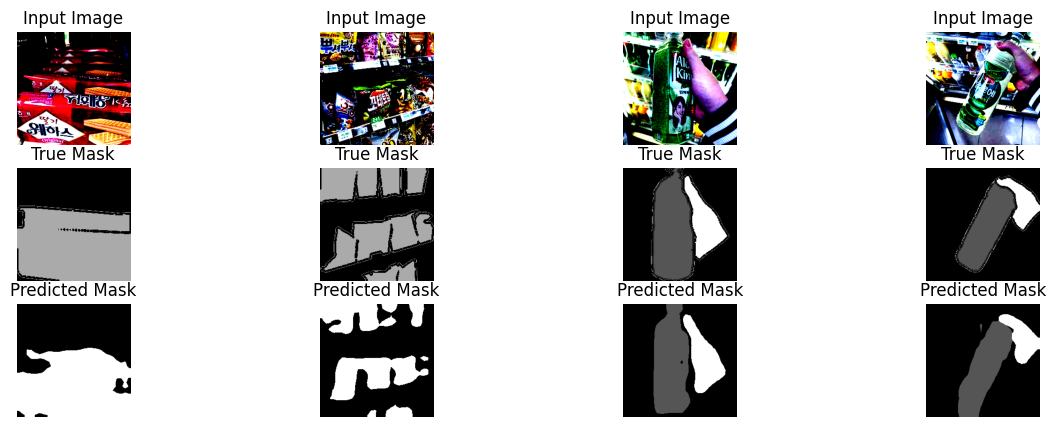

Epoch 21/100: 100%|██████████| 7/7 [00:02<00:00,  2.86batch/s]


Epoch [21/100], Loss: 0.1898
Epoch [21/100], Validation Loss: 0.4135


Epoch 22/100: 100%|██████████| 7/7 [00:02<00:00,  2.92batch/s]


Epoch [22/100], Loss: 0.1900
Epoch [22/100], Validation Loss: 0.4121


Epoch 23/100: 100%|██████████| 7/7 [00:02<00:00,  2.98batch/s]


Epoch [23/100], Loss: 0.1857
Epoch [23/100], Validation Loss: 0.4078
Saved best model with validation loss: 0.4078


Epoch 24/100: 100%|██████████| 7/7 [00:02<00:00,  2.94batch/s]


Epoch [24/100], Loss: 0.1858
Epoch [24/100], Validation Loss: 0.4100


Epoch 25/100: 100%|██████████| 7/7 [00:02<00:00,  2.83batch/s]


Epoch [25/100], Loss: 0.1825
Epoch [25/100], Validation Loss: 0.4126


Epoch 26/100: 100%|██████████| 7/7 [00:02<00:00,  2.95batch/s]


Epoch [26/100], Loss: 0.1845
Epoch [26/100], Validation Loss: 0.4145


Epoch 27/100: 100%|██████████| 7/7 [00:02<00:00,  2.75batch/s]


Epoch [27/100], Loss: 0.1822
Epoch [27/100], Validation Loss: 0.4165


Epoch 28/100: 100%|██████████| 7/7 [00:02<00:00,  2.94batch/s]


Epoch [28/100], Loss: 0.1796
Epoch [28/100], Validation Loss: 0.4217


Epoch 29/100: 100%|██████████| 7/7 [00:02<00:00,  2.89batch/s]


Epoch [29/100], Loss: 0.1816
Epoch [29/100], Validation Loss: 0.4195


Epoch 30/100: 100%|██████████| 7/7 [00:02<00:00,  2.98batch/s]


Epoch [30/100], Loss: 0.1839
Epoch [30/100], Validation Loss: 0.4263


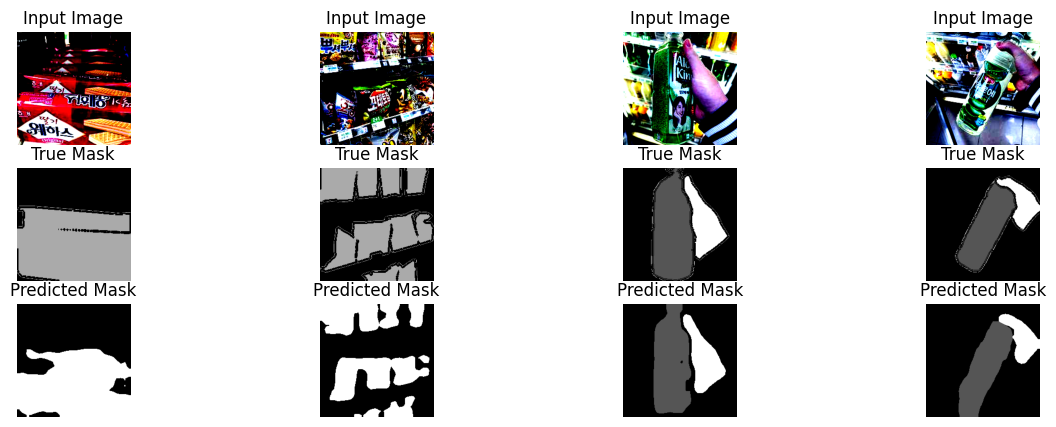

Epoch 31/100: 100%|██████████| 7/7 [00:02<00:00,  2.92batch/s]


Epoch [31/100], Loss: 0.1848
Epoch [31/100], Validation Loss: 0.4281


Epoch 32/100: 100%|██████████| 7/7 [00:02<00:00,  2.99batch/s]


Epoch [32/100], Loss: 0.1785
Epoch [32/100], Validation Loss: 0.4193


Epoch 33/100: 100%|██████████| 7/7 [00:02<00:00,  2.98batch/s]


Epoch [33/100], Loss: 0.1808
Epoch [33/100], Validation Loss: 0.4233


Epoch 34/100: 100%|██████████| 7/7 [00:02<00:00,  2.91batch/s]


Epoch [34/100], Loss: 0.1777
Epoch [34/100], Validation Loss: 0.4221


Epoch 35/100: 100%|██████████| 7/7 [00:02<00:00,  2.93batch/s]


Epoch [35/100], Loss: 0.1832
Epoch [35/100], Validation Loss: 0.4171


Epoch 36/100: 100%|██████████| 7/7 [00:02<00:00,  2.88batch/s]


Epoch [36/100], Loss: 0.1791
Epoch [36/100], Validation Loss: 0.4149


Epoch 37/100: 100%|██████████| 7/7 [00:02<00:00,  2.84batch/s]


Epoch [37/100], Loss: 0.1794
Epoch [37/100], Validation Loss: 0.4174


Epoch 38/100: 100%|██████████| 7/7 [00:02<00:00,  2.99batch/s]


Epoch [38/100], Loss: 0.1773
Epoch [38/100], Validation Loss: 0.4174


Epoch 39/100: 100%|██████████| 7/7 [00:02<00:00,  2.94batch/s]


Epoch [39/100], Loss: 0.1792
Epoch [39/100], Validation Loss: 0.4158


Epoch 40/100: 100%|██████████| 7/7 [00:02<00:00,  3.00batch/s]


Epoch [40/100], Loss: 0.1791
Epoch [40/100], Validation Loss: 0.4204


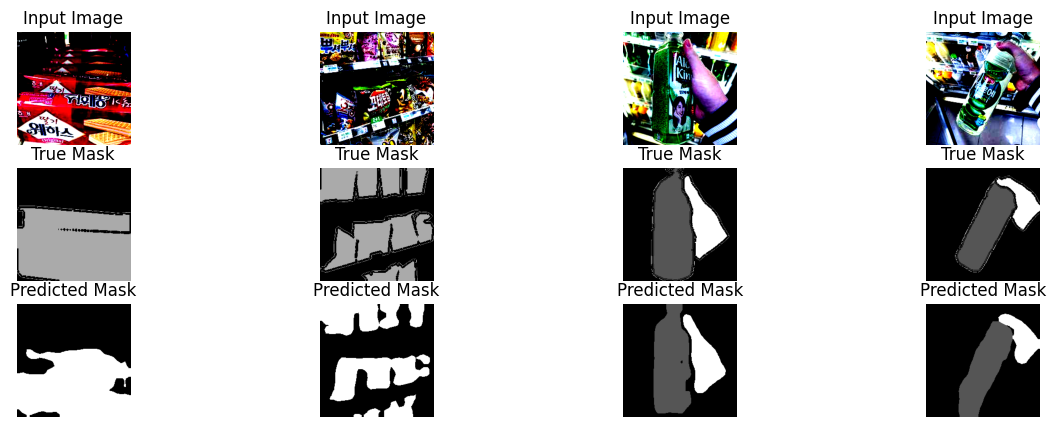

Epoch 41/100: 100%|██████████| 7/7 [00:02<00:00,  2.91batch/s]


Epoch [41/100], Loss: 0.1850
Epoch [41/100], Validation Loss: 0.4144


Epoch 42/100: 100%|██████████| 7/7 [00:02<00:00,  2.94batch/s]


Epoch [42/100], Loss: 0.1797
Epoch [42/100], Validation Loss: 0.4148


Epoch 43/100: 100%|██████████| 7/7 [00:02<00:00,  2.85batch/s]


Epoch [43/100], Loss: 0.1815
Epoch [43/100], Validation Loss: 0.4131


Epoch 44/100: 100%|██████████| 7/7 [00:02<00:00,  2.94batch/s]


Epoch [44/100], Loss: 0.1772
Epoch [44/100], Validation Loss: 0.4174


Epoch 45/100: 100%|██████████| 7/7 [00:02<00:00,  2.97batch/s]


Epoch [45/100], Loss: 0.1765
Epoch [45/100], Validation Loss: 0.4158


Epoch 46/100: 100%|██████████| 7/7 [00:02<00:00,  2.96batch/s]


Epoch [46/100], Loss: 0.1809
Epoch [46/100], Validation Loss: 0.4146


Epoch 47/100: 100%|██████████| 7/7 [00:02<00:00,  2.99batch/s]


Epoch [47/100], Loss: 0.1801
Epoch [47/100], Validation Loss: 0.4149


Epoch 48/100: 100%|██████████| 7/7 [00:02<00:00,  2.96batch/s]


Epoch [48/100], Loss: 0.1788
Epoch [48/100], Validation Loss: 0.4178


Epoch 49/100: 100%|██████████| 7/7 [00:02<00:00,  2.92batch/s]


Epoch [49/100], Loss: 0.1770
Epoch [49/100], Validation Loss: 0.4176


Epoch 50/100: 100%|██████████| 7/7 [00:02<00:00,  2.85batch/s]


Epoch [50/100], Loss: 0.1804
Epoch [50/100], Validation Loss: 0.4164


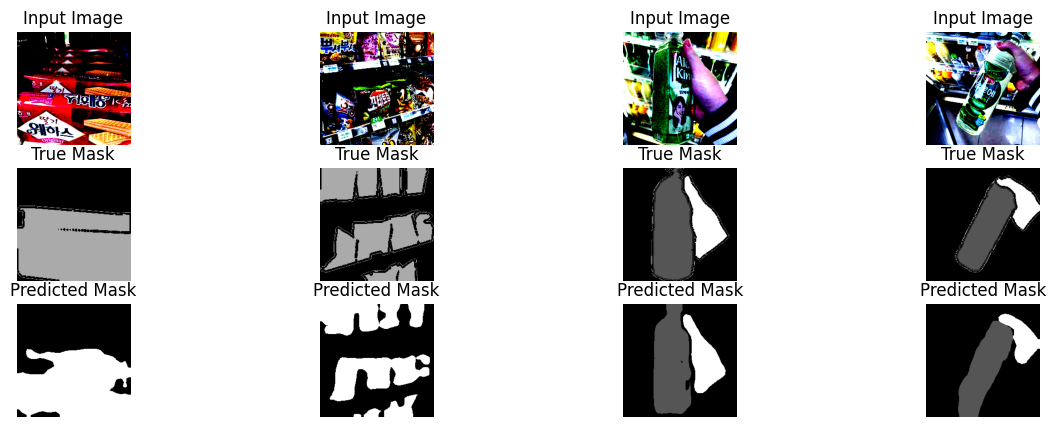

Epoch 51/100: 100%|██████████| 7/7 [00:02<00:00,  2.92batch/s]


Epoch [51/100], Loss: 0.1850
Epoch [51/100], Validation Loss: 0.4167


Epoch 52/100: 100%|██████████| 7/7 [00:02<00:00,  2.91batch/s]


Epoch [52/100], Loss: 0.1788
Epoch [52/100], Validation Loss: 0.4183


Epoch 53/100: 100%|██████████| 7/7 [00:02<00:00,  2.90batch/s]


Epoch [53/100], Loss: 0.1854
Epoch [53/100], Validation Loss: 0.4236


Epoch 54/100: 100%|██████████| 7/7 [00:02<00:00,  3.01batch/s]


Epoch [54/100], Loss: 0.1847
Epoch [54/100], Validation Loss: 0.4209


Epoch 55/100: 100%|██████████| 7/7 [00:02<00:00,  2.83batch/s]


Epoch [55/100], Loss: 0.1780
Epoch [55/100], Validation Loss: 0.4236


Epoch 56/100: 100%|██████████| 7/7 [00:02<00:00,  2.98batch/s]


Epoch [56/100], Loss: 0.1785
Epoch [56/100], Validation Loss: 0.4166


Epoch 57/100: 100%|██████████| 7/7 [00:02<00:00,  2.97batch/s]


Epoch [57/100], Loss: 0.1814
Epoch [57/100], Validation Loss: 0.4173


Epoch 58/100: 100%|██████████| 7/7 [00:02<00:00,  2.84batch/s]


Epoch [58/100], Loss: 0.1803
Epoch [58/100], Validation Loss: 0.4176


Epoch 59/100: 100%|██████████| 7/7 [00:02<00:00,  2.91batch/s]


Epoch [59/100], Loss: 0.1792
Epoch [59/100], Validation Loss: 0.4145


Epoch 60/100: 100%|██████████| 7/7 [00:04<00:00,  1.55batch/s]


Epoch [60/100], Loss: 0.1814
Epoch [60/100], Validation Loss: 0.4202


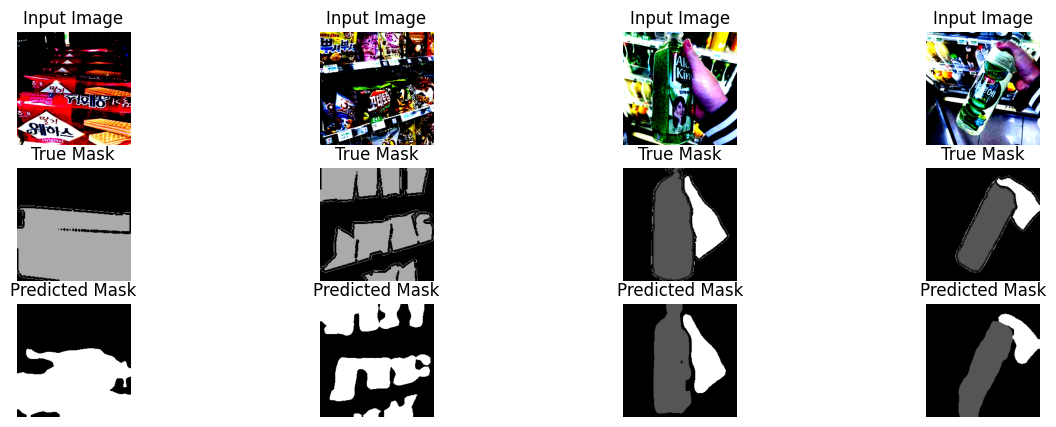

Epoch 61/100: 100%|██████████| 7/7 [00:02<00:00,  3.01batch/s]


Epoch [61/100], Loss: 0.1771
Epoch [61/100], Validation Loss: 0.4208


Epoch 62/100: 100%|██████████| 7/7 [00:02<00:00,  3.01batch/s]


Epoch [62/100], Loss: 0.1774
Epoch [62/100], Validation Loss: 0.4182


Epoch 63/100: 100%|██████████| 7/7 [00:02<00:00,  2.97batch/s]


Epoch [63/100], Loss: 0.1793
Epoch [63/100], Validation Loss: 0.4198


Epoch 64/100: 100%|██████████| 7/7 [00:02<00:00,  2.95batch/s]


Epoch [64/100], Loss: 0.1775
Epoch [64/100], Validation Loss: 0.4158


Epoch 65/100: 100%|██████████| 7/7 [00:02<00:00,  2.71batch/s]


Epoch [65/100], Loss: 0.1832
Epoch [65/100], Validation Loss: 0.4213


Epoch 66/100: 100%|██████████| 7/7 [00:02<00:00,  2.92batch/s]


Epoch [66/100], Loss: 0.1779
Epoch [66/100], Validation Loss: 0.4151


Epoch 67/100: 100%|██████████| 7/7 [00:02<00:00,  2.85batch/s]


Epoch [67/100], Loss: 0.1815
Epoch [67/100], Validation Loss: 0.4143


Epoch 68/100: 100%|██████████| 7/7 [00:02<00:00,  2.94batch/s]


Epoch [68/100], Loss: 0.1825
Epoch [68/100], Validation Loss: 0.4146


Epoch 69/100: 100%|██████████| 7/7 [00:02<00:00,  2.89batch/s]


Epoch [69/100], Loss: 0.1794
Epoch [69/100], Validation Loss: 0.4144


Epoch 70/100: 100%|██████████| 7/7 [00:02<00:00,  2.97batch/s]


Epoch [70/100], Loss: 0.1807
Epoch [70/100], Validation Loss: 0.4146


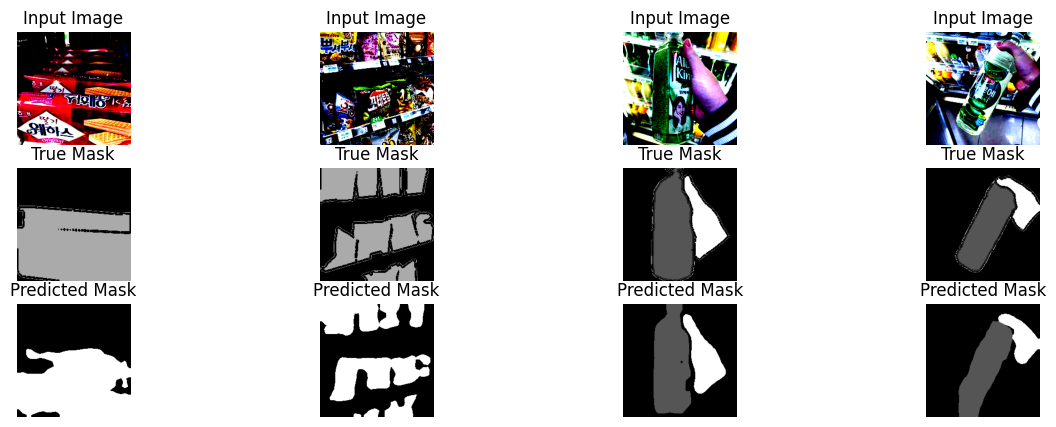

Epoch 71/100: 100%|██████████| 7/7 [00:02<00:00,  2.96batch/s]


Epoch [71/100], Loss: 0.1811
Epoch [71/100], Validation Loss: 0.4173


Epoch 72/100: 100%|██████████| 7/7 [00:02<00:00,  2.94batch/s]


Epoch [72/100], Loss: 0.1828
Epoch [72/100], Validation Loss: 0.4143


Epoch 73/100: 100%|██████████| 7/7 [00:02<00:00,  2.93batch/s]


Epoch [73/100], Loss: 0.1793
Epoch [73/100], Validation Loss: 0.4198


Epoch 74/100: 100%|██████████| 7/7 [00:02<00:00,  2.88batch/s]


Epoch [74/100], Loss: 0.1792
Epoch [74/100], Validation Loss: 0.4180


Epoch 75/100: 100%|██████████| 7/7 [00:02<00:00,  2.92batch/s]


Epoch [75/100], Loss: 0.1792
Epoch [75/100], Validation Loss: 0.4154


Epoch 76/100: 100%|██████████| 7/7 [00:02<00:00,  2.92batch/s]


Epoch [76/100], Loss: 0.1803
Epoch [76/100], Validation Loss: 0.4143


Epoch 77/100: 100%|██████████| 7/7 [00:02<00:00,  2.95batch/s]


Epoch [77/100], Loss: 0.1788
Epoch [77/100], Validation Loss: 0.4202


Epoch 78/100: 100%|██████████| 7/7 [00:02<00:00,  2.91batch/s]


Epoch [78/100], Loss: 0.1777
Epoch [78/100], Validation Loss: 0.4191


Epoch 79/100: 100%|██████████| 7/7 [00:02<00:00,  2.90batch/s]


Epoch [79/100], Loss: 0.1783
Epoch [79/100], Validation Loss: 0.4193


Epoch 80/100: 100%|██████████| 7/7 [00:02<00:00,  2.91batch/s]


Epoch [80/100], Loss: 0.1793
Epoch [80/100], Validation Loss: 0.4192


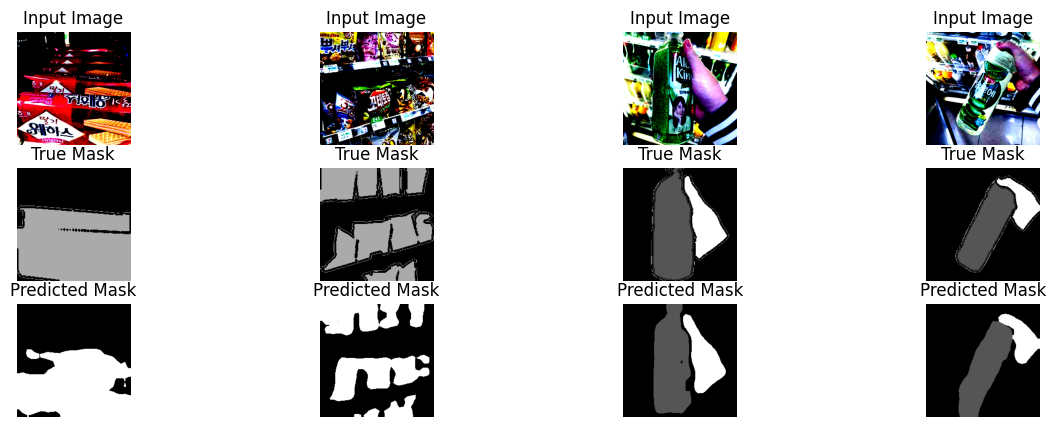

Epoch 81/100: 100%|██████████| 7/7 [00:02<00:00,  2.97batch/s]


Epoch [81/100], Loss: 0.1773
Epoch [81/100], Validation Loss: 0.4185


Epoch 82/100: 100%|██████████| 7/7 [00:02<00:00,  2.96batch/s]


Epoch [82/100], Loss: 0.1788
Epoch [82/100], Validation Loss: 0.4203


Epoch 83/100: 100%|██████████| 7/7 [00:02<00:00,  2.99batch/s]


Epoch [83/100], Loss: 0.1784
Epoch [83/100], Validation Loss: 0.4200


Epoch 84/100: 100%|██████████| 7/7 [00:02<00:00,  2.93batch/s]


Epoch [84/100], Loss: 0.1787
Epoch [84/100], Validation Loss: 0.4160


Epoch 85/100: 100%|██████████| 7/7 [00:02<00:00,  2.92batch/s]


Epoch [85/100], Loss: 0.1803
Epoch [85/100], Validation Loss: 0.4193


Epoch 86/100: 100%|██████████| 7/7 [00:02<00:00,  2.95batch/s]


Epoch [86/100], Loss: 0.1826
Epoch [86/100], Validation Loss: 0.4191


Epoch 87/100: 100%|██████████| 7/7 [00:02<00:00,  2.96batch/s]


Epoch [87/100], Loss: 0.1785
Epoch [87/100], Validation Loss: 0.4158


Epoch 88/100: 100%|██████████| 7/7 [00:02<00:00,  2.97batch/s]


Epoch [88/100], Loss: 0.1796
Epoch [88/100], Validation Loss: 0.4160


Epoch 89/100: 100%|██████████| 7/7 [00:02<00:00,  2.95batch/s]


Epoch [89/100], Loss: 0.1815
Epoch [89/100], Validation Loss: 0.4194


Epoch 90/100: 100%|██████████| 7/7 [00:02<00:00,  2.87batch/s]


Epoch [90/100], Loss: 0.1790
Epoch [90/100], Validation Loss: 0.4190


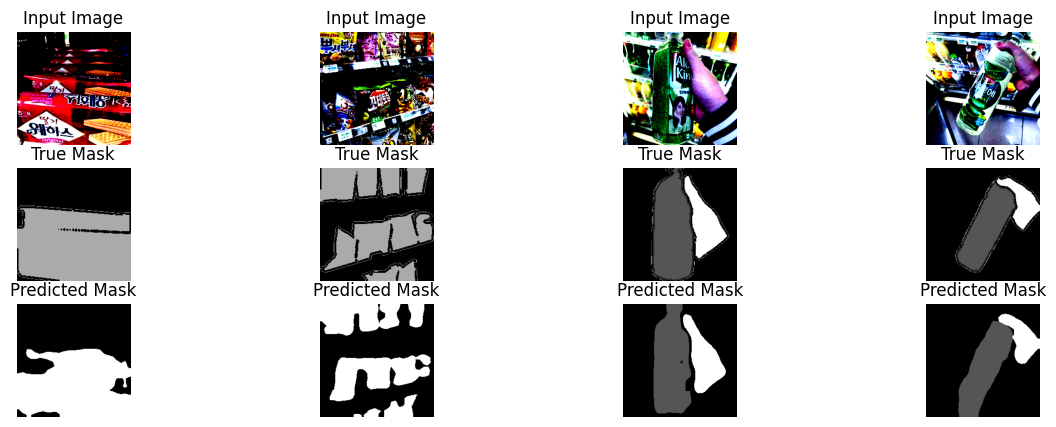

Epoch 91/100: 100%|██████████| 7/7 [00:02<00:00,  2.98batch/s]


Epoch [91/100], Loss: 0.1811
Epoch [91/100], Validation Loss: 0.4208


Epoch 92/100: 100%|██████████| 7/7 [00:02<00:00,  3.00batch/s]


Epoch [92/100], Loss: 0.1790
Epoch [92/100], Validation Loss: 0.4187


Epoch 93/100: 100%|██████████| 7/7 [00:02<00:00,  2.96batch/s]


Epoch [93/100], Loss: 0.1799
Epoch [93/100], Validation Loss: 0.4179


Epoch 94/100: 100%|██████████| 7/7 [00:02<00:00,  2.93batch/s]


Epoch [94/100], Loss: 0.1789
Epoch [94/100], Validation Loss: 0.4187


Epoch 95/100: 100%|██████████| 7/7 [00:02<00:00,  2.93batch/s]


Epoch [95/100], Loss: 0.1794
Epoch [95/100], Validation Loss: 0.4179


Epoch 96/100: 100%|██████████| 7/7 [00:02<00:00,  2.90batch/s]


Epoch [96/100], Loss: 0.1784
Epoch [96/100], Validation Loss: 0.4188


Epoch 97/100: 100%|██████████| 7/7 [00:02<00:00,  2.96batch/s]


Epoch [97/100], Loss: 0.1786
Epoch [97/100], Validation Loss: 0.4192


Epoch 98/100: 100%|██████████| 7/7 [00:02<00:00,  3.01batch/s]


Epoch [98/100], Loss: 0.1809
Epoch [98/100], Validation Loss: 0.4238


Epoch 99/100: 100%|██████████| 7/7 [00:02<00:00,  2.95batch/s]


Epoch [99/100], Loss: 0.1782
Epoch [99/100], Validation Loss: 0.4187


Epoch 100/100: 100%|██████████| 7/7 [00:02<00:00,  2.96batch/s]


Epoch [100/100], Loss: 0.1785
Epoch [100/100], Validation Loss: 0.4184
Saved last model


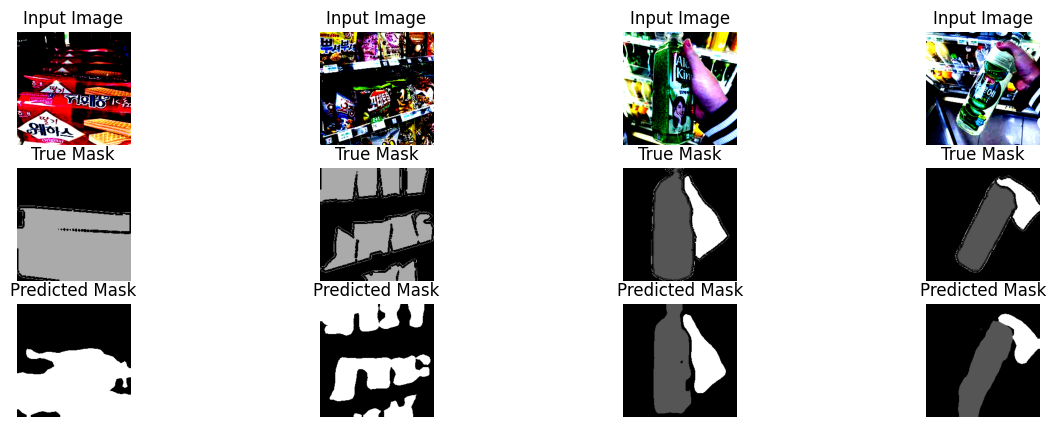

In [7]:
num_epochs = 100

best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}")

    # 학습률 스케줄러 업데이트
    scheduler.step(val_loss)

    # 최상의 검증 손실 모델 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), './pt/best_dl50_224_2.pt')
        print(f"Saved best model with validation loss: {best_val_loss:.4f}")

    # 마지막 에포크의 모델 저장
    if epoch == num_epochs - 1:
        torch.save(model.state_dict(), './pt/last_dl50_224_2.pt')
        print("Saved last model")

    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            for idx, (images, masks) in enumerate(val_loader):
                if idx >= 1:  # 한 배치만 시각화
                    break
                images = images.to(device)
                masks = masks.to(device)
                outputs = model(images)['out']
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                images = images.cpu().numpy().transpose(0, 2, 3, 1)
                masks = masks.cpu().numpy()
                
                plt.figure(figsize=(15, 5))
                for i in range(min(4, len(images))):  # 최대 4개의 이미지를 시각화
                    plt.subplot(3, 4, i + 1)
                    plt.imshow(np.clip(images[i], 0, 1))  # 클리핑
                    plt.title("Input Image")
                    plt.axis("off")

                    plt.subplot(3, 4, i + 5)
                    plt.imshow(masks[i], cmap='gray')
                    plt.title("True Mask")
                    plt.axis("off")

                    plt.subplot(3, 4, i + 9)
                    plt.imshow(preds[i], cmap='gray')
                    plt.title("Predicted Mask")
                    plt.axis("off")
                plt.show()
